In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageDraw

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf

from data_prep import data_prep

seed = 42
np.random.seed(seed)

In [2]:
# Read datasets
dfbio = pd.read_csv('Shell.ai Hackathon 2023\dataset\Biomass_History.csv')
dfdist = pd.read_csv('Shell.ai Hackathon 2023\dataset\Distance_Matrix.csv')
submission = pd.read_csv('Shell.ai Hackathon 2023\dataset\sample_submission.csv')
dfext = pd.read_excel('Shell.ai Hackathon 2023\dataset\External_Data.xlsx')
dfreal = pd.read_csv('Shell.ai Hackathon 2023\dataset\Biomass_Private.csv')

In [296]:
data_loader = data_prep()
data_loader.create_images()
# data_loader.save_images()
selected_pix = data_loader.selected_pix
images = data_loader.get_images()

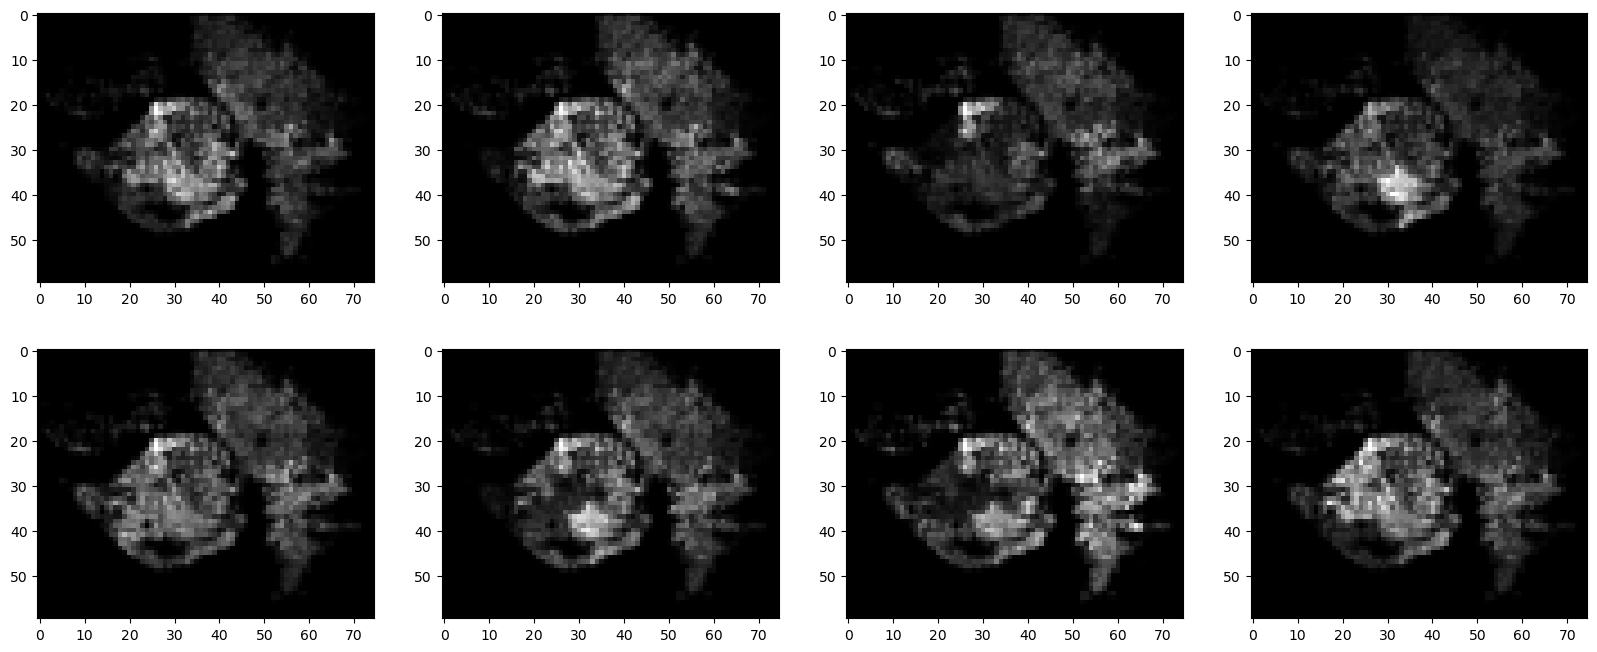

In [4]:
fig, axes = plt.subplots(2,4, figsize=(20,8))
for i,image in enumerate(images):
    axes.flatten()[i].imshow(image, cmap='gray')

In [297]:
def image_to_list(image, selected=selected_pix):
    image = np.reshape(image, (60,75))
    return np.array([image[x,y] for y, x in selected])

def tf_image_to_list(x):
    return tf.gather_nd(x[0,:,:,0], [(h,w) for w,h in selected_pix])

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data)-seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    X = np.array(sequences)
    y = np.array(targets)
    return X[..., np.newaxis], y

In [298]:
images = np.log1p(images)

In [299]:
train = images[:-1]
val = images[-1:]

In [300]:
seq_len = 3

X_train, y_train = create_sequences(train, seq_len)
X_val, y_val = create_sequences(np.concatenate([train[-seq_len:], val]), seq_len)

In [301]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((4, 3, 60, 75, 1), (4, 60, 75), (1, 3, 60, 75, 1), (1, 60, 75))

In [302]:
_, frames, height, width, channels = X_train.shape

In [303]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, ConvLSTM2D, Conv2D, Conv3D, BatchNormalization, Flatten, Dense, Dropout, Lambda, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [304]:
model = Sequential([
    ConvLSTM2D(filters=128, kernel_size=(5, 5), activation='relu', input_shape=(frames, height, width, channels), padding='same', return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    BatchNormalization(),
    ConvLSTM2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same', return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    BatchNormalization(),
    ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    BatchNormalization(),
    Conv2D(filters=channels, kernel_size=(1,1), activation='sigmoid', padding='same')
])
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_111 (ConvLSTM2  (None, 3, 60, 75, 128)    1651712   
 D)                                                              
                                                                 
 batch_normalization_111 (B  (None, 3, 60, 75, 128)    512       
 atchNormalization)                                              
                                                                 
 conv_lstm2d_112 (ConvLSTM2  (None, 3, 60, 75, 64)     1229056   
 D)                                                              
                                                                 
 batch_normalization_112 (B  (None, 3, 60, 75, 64)     256       
 atchNormalization)                                              
                                                                 
 conv_lstm2d_113 (ConvLSTM2  (None, 60, 75, 64)      

In [305]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=10)

In [306]:
# Train the model with early stopping
history = model.fit(
    X_train, y_train, 
    epochs=200, 
    batch_size=16, 
    verbose=1, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss = model.evaluate(X_val, y_val)

Epoch 1/200
1/1 [==============================] - 16s 16s/step - loss: 2.1810 - val_loss: 2.2421
Epoch 2/200
1/1 [==============================] - 9s 9s/step - loss: 1.8026 - val_loss: 2.2351
Epoch 3/200
1/1 [==============================] - 9s 9s/step - loss: 1.7651 - val_loss: 2.2251
Epoch 4/200
1/1 [==============================] - 9s 9s/step - loss: 1.7630 - val_loss: 2.2048
Epoch 5/200
1/1 [==============================] - 9s 9s/step - loss: 1.7540 - val_loss: 2.1639
Epoch 6/200
1/1 [==============================] - 9s 9s/step - loss: 1.7509 - val_loss: 2.1131
Epoch 7/200
1/1 [==============================] - 9s 9s/step - loss: 1.7498 - val_loss: 2.0866
Epoch 8/200
1/1 [==============================] - 9s 9s/step - loss: 1.7465 - val_loss: 2.0741
Epoch 9/200
1/1 [==============================] - 9s 9s/step - loss: 1.7467 - val_loss: 2.0651
Epoch 10/200
1/1 [==============================] - 9s 9s/step - loss: 1.7430 - val_loss: 2.0612
Epoch 11/200
1/1 [===================

KeyboardInterrupt: 

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# model.save_weights("models/CLSTM553_100E.h5")
# model.load_weights("models/CLSTM553_100E.h5")

In [26]:
y_val_pred = model.predict(X_val)

1/1 [==============================] - 1s 1s/step


In [35]:
pred_2018 = scaler.inv_transform(y_val_pred[0,:,:,0])

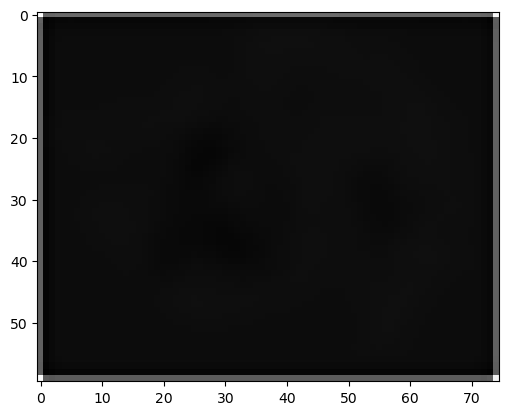

In [41]:
plt.imshow(scaler.inv_transform(y_val_pred[0,:,:,0]), cmap='gray')

In [44]:
mean_absolute_error(y_val[0,:], y_val_pred[0,:,:,0])

0.08049495

In [45]:
0.08049495*1200

96.59393999999999

In [43]:
y_val[0,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15,6))
axes.flatten()[0].imshow(y_val_pred[0,:,:,0], cmap='gray')
axes.flatten()[1].imshow(y_val[0,:], cmap='gray')
axes.flatten()[2].imshow(y_val_pred[1,:,:,0], cmap='gray')
axes.flatten()[3].imshow(y_val[1,:], cmap='gray')
plt.tight_layout()
plt.show()

In [ ]:
mean_absolute_error(y_val[0,:], y_val_pred[0,:,:,0])